# Features from Scouting - Percentiles

Load the training data into a pandas data frame.  

In [1]:
from __future__ import print_function
#import time
import sys
import pickle
sys.path.append('..')
import swagger_client as v3client
from swagger_client.rest import ApiException

filename = '../matches.pkl'
matches = []
with open(filename, 'rb') as f:
    matches = pickle.load(f)

    
scoutingStats = {}
with open('../scoutingStats.pkl', 'rb') as f:
    scoutingStats = pickle.load(f)
    

Preview a match object

In [2]:
scoutingStats['frc492']

{'matchCount': 11,
 'SP-Autonomous': 0.36363636363636365,
 'SP-Off Platform': 0.9090909090909091,
 'SP-Cross Line': 0.8181818181818182,
 'SP-RocketHatchLow': 0.09090909090909091,
 'SP-RocketHatchMid': 0.18181818181818182,
 'SP-RocketHatchHigh': 0.18181818181818182,
 'SP-RocketHatchDropped': 0.18181818181818182,
 'SP-RocketCargoLow': 0.18181818181818182,
 'SP-RocketCargoMid': 0.0,
 'SP-RocketCargoHigh': 0.0,
 'SP-RocketCargoDropped': 0.0,
 'SP-CargoShipHatches': 0.09090909090909091,
 'SP-CargoShipCargo': 0.09090909090909091,
 'CP-Defense': 0.0,
 'CP-RocketHatchLow': 1.0,
 'CP-RocketHatchMid': 1.0,
 'CP-RocketHatchHigh': 0.36363636363636365,
 'CP-RocketHatchDropped': 0.6363636363636364,
 'CP-HatchFromLoadingZone': 0.0,
 'CP-RocketCargoLow': 1.0909090909090908,
 'CP-RocketCargoMid': 0.45454545454545453,
 'CP-RocketCargoHigh': 0.0,
 'CP-RocketCargoDropped': 0.09090909090909091,
 'CP-CargoFromLoadingZone': 0.45454545454545453,
 'CP-CargoShipHatches': 0.2727272727272727,
 'CP-CargoShipCargo'

As you can see there is a lot of information here.  Suppose we want to collect all of this together so that at the end of the regionals we have score statistics for every team.  Let's aggregate stats for each of these fields: 'totalMatches', 
'autoPoints', 'cargoPoints', 'completeRocketRankingPoints', 'completedRocketCount', 'habLevel1Count', 'habLevel2Count', 'habLevel3Count', 'foulCount', 'foulPoints', 'rocketPanelCount', 'rocketCargoCount', 'bayPanelCount', 'bayCargoCount', 'habLineCount', 'habDockingRankingPoints', 'habClimbPoints', 'hatchPanelPoints', 'rankingPoints', 'sandStormBonusPoints', 'techFoulCount', 'teleopPoints', 'totalPoints', 'winCount'

In [3]:
teamAggregates = {}

def addMatch(team, m):    
    if team not in teamAggregates:       
        # initialize an empty record for the team.
        teamAggregates[team]= {
            'totalMatches':0, 
            'autoPoints':0, 
            'cargoPoints':0, 
            'completeRocketRankingPoints':0, 
            'completedRocketCount':0, 
            'habLevel1Count':0, 
            'habLevel2Count':0, 
            'habLevel3Count':0,             
            'foulCount':0, 
            'foulPoints':0, 
            'rocketPanelCount':0, 
            'rocketCargoCount':0, 
            'bayPanelCount':0, 
            'bayCargoCount':0, 
            'habLineCount':0, 
            'habDockingRankingPoints':0, 
            'habClimbPoints':0, 
            'hatchPanelPoints':0, 
            'rankingPoints':0, 
            'sandStormBonusPoints':0, 
            'techFoulCount':0, 
            'teleopPoints':0, 
            'totalPoints':0, 
            'winCount':0
        }

    alliance = 'blue' if team in m.alliances.blue.team_keys else 'red'
    points = m.score_breakdown[alliance]
    summary = teamAggregates[team]
    # update all of the fields.
    summary['totalMatches']+=1    
    summary['autoPoints']+=points['autoPoints']
    summary['cargoPoints']+=points['cargoPoints'] 
    summary['completeRocketRankingPoints']+=int(points['completeRocketRankingPoint']) 
    summary['completedRocketCount']+=int(points['completedRocketFar'])+int(points['completedRocketNear'])
    for r in [1,2,3]:
        l = points['endgameRobot'+str(r)]
        if l=='HabLevel1':
            summary['habLevel1Count']+=1
        elif l=='HabLevel2':
            summary['habLevel2Count']+=1
        elif l=='HabLevel3':
            summary['habLevel3Count']+=1
        h = points['habLineRobot'+str(r)]
        if h=='CrossedHabLineInSandstorm':
            summary['habLineCount']+=1

    summary['foulCount']+=points['foulCount']
    summary['foulPoints']+=points['foulPoints']
    
    # Rocket cargo and panel positions
    for l in ['low','mid','top']:
            for s in ['Left','Right']:
                for n in ['Near','Far']:
                    r = l+s+'Rocket'+n  #e.g. lowLeftRocketNear
                    if points[r]=='Panel':
                        summary['rocketPanelCount']+=1
                    if points[r]=='PanelAndCargo':
                        summary['rocketPanelCount']+=1
                        summary['rocketCargoCount']+=1
    # bays 1:8                 
    for b in range(1,9): 
        bay = 'bay'+str(b)
        if points[bay]=='Panel':
            summary['bayPanelCount']+=1
        if points[bay]=='PanelAndCargo':
            summary['bayPanelCount']+=1
            summary['bayCargoCount']+=1
            
    summary['habDockingRankingPoints']+=int(points['habDockingRankingPoint'])
    summary['habClimbPoints']+=points['habClimbPoints'] 
    summary['hatchPanelPoints']+=points['hatchPanelPoints']
    summary['rankingPoints']+=points['rp']
    summary['sandStormBonusPoints']+=points['sandStormBonusPoints']
    summary['techFoulCount']+=points['techFoulCount']
    summary['teleopPoints']+=points['teleopPoints']
    summary['totalPoints']+=points['totalPoints']
    summary['winCount']+=int(m.winning_alliance==alliance)


for m in matches:
    # only aggregate statistics for regional matches- skip the districts or we're cheating.
    if m.event_key=='2019pncmp':
        continue
    for t in m.alliances.red.team_keys:
        addMatch(t,m)
    for t in m.alliances.blue.team_keys:
        addMatch(t,m)
        
# normalize the aggregates
for t in teamAggregates:
    for k in ['autoPoints', 'cargoPoints', 'completeRocketRankingPoints', 'completedRocketCount', 'habLevel1Count', 'habLevel2Count', 'habLevel3Count', 'foulCount', 'foulPoints', 'rocketPanelCount', 'rocketCargoCount', 'bayPanelCount', 'bayCargoCount', 'habLineCount', 'habDockingRankingPoints', 'habClimbPoints', 'hatchPanelPoints', 'rankingPoints', 'sandStormBonusPoints', 'techFoulCount', 'teleopPoints', 'totalPoints', 'winCount']:
        teamAggregates[t][k]/=teamAggregates[t]['totalMatches']

with open('../teamStats.pkl','wb') as f:
    pickle.dump(teamAggregates,f)

In [4]:
teamAggregates['frc492']

{'totalMatches': 28,
 'autoPoints': 11.25,
 'cargoPoints': 18.214285714285715,
 'completeRocketRankingPoints': 0.03571428571428571,
 'completedRocketCount': 0.03571428571428571,
 'habLevel1Count': 1.5,
 'habLevel2Count': 0.2857142857142857,
 'habLevel3Count': 0.75,
 'foulCount': 0.25,
 'foulPoints': 2.5,
 'rocketPanelCount': 4.25,
 'rocketCargoCount': 2.3214285714285716,
 'bayPanelCount': 6.571428571428571,
 'bayCargoCount': 3.75,
 'habLineCount': 2.857142857142857,
 'habDockingRankingPoints': 0.6428571428571429,
 'habClimbPoints': 15.214285714285714,
 'hatchPanelPoints': 11.571428571428571,
 'rankingPoints': 1.6785714285714286,
 'sandStormBonusPoints': 11.25,
 'techFoulCount': 0.03571428571428571,
 'teleopPoints': 45.0,
 'totalPoints': 58.75,
 'winCount': 0.5}

In [48]:
def percentile(dictionary, key):
    teams = [t for t in dictionary]
    values = [dictionary[t][key] for t in dictionary]
    ranks = sorted(range(len(values)), key=lambda x: values[x])
    return dict([(teams[ranks[i]], i*100/len(values)) for i in range(len(ranks))])    

raw = dict([(k, percentile(teamAggregates,k)) for k in teamAggregates['frc492']])
        
        
#[(k,percentile(scoutingStats,k)['frc492']) for k in scoutingStats['frc492']]
#stats = dict([(k,percentile(teamAggregates,k)['frc492']) for k in teamAggregates['frc492']])
#stats
#teamAggregates['frc1983']['totalPoints']

#[(t,teamAggregates[t]['totalPoints']) for t in teamAggregates]

#X = [3, 7, 8, 2, 5]
#from numpy import argsort
#argsort(X)


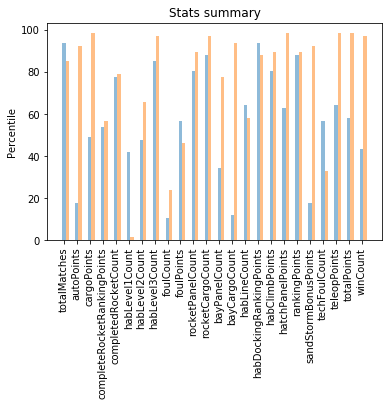

In [62]:
import matplotlib.pyplot as plt
import numpy as np

objects = [k for k in stats]
y_pos = np.arange(len(objects))
#performance = [[raw[k]['frc492'],raw[k]['frc2910']] for k in stats]
#performance
plt.bar(y_pos, [raw[k]['frc492'] for k in stats], alpha=0.5, width=0.25)
plt.bar(y_pos+0.25, [raw[k]['frc2910'] for k in stats], alpha=0.5, width=0.25)
plt.xticks(y_pos, objects, rotation=90)
plt.ylabel('Percentile')
plt.title('Stats summary')

plt.show()


Now we have statistics for every team.  We can use this to generate features for every match.

In [23]:

def featurizeMatch(m):
    match_features = { 'red_missingCount':0, 'red_missingScouting':0, 'blue_missingCount': 0, 'blue_missingScouting':0, }
    statsCount=0    
    scoutingCount=0
    allKeys = set()
    for t in m.alliances.red.team_keys:
        if t not in teamAggregates:
            match_features['red_missingCount']+=1
        else:
            for k in teamAggregates[t]:
                key = 'red_'+k;
                if key not in match_features:
                    match_features[key]=0
                match_features[key]+=teamAggregates[t][k]
                allKeys.add(key)
            statsCount+=1
        if t not in scoutingStats:
            match_features['red_missingScouting']+=1
        else:
            for k in scoutingStats[t]:
                key = 'red_'+k;
                if key not in match_features:
                    match_features[key]=0
                match_features[key]+=scoutingStats[t][k]
                allKeys.add(key)
            scoutingCount+=1
    # compute the average
    for k in allKeys:
        match_features[k]/=statsCount
    statsCount=0
    scoutingCount=0
    allKeys=set()
    for t in m.alliances.blue.team_keys:
        if t not in teamAggregates:
            match_features['blue_missingCount']+=1
        else:
            for k in teamAggregates[t]:
                key = 'blue_'+k;
                if key not in match_features:
                    match_features[key]=0
                match_features[key]+=teamAggregates[t][k]
                allKeys.add(key)
            statsCount+=1
        if t not in scoutingStats:
            match_features['blue_missingScouting']+=1
        else:
            for k in scoutingStats[t]:
                key = 'blue_'+k;
                if key not in match_features:
                    match_features[key]=0
                match_features[key]+=scoutingStats[t][k]
                allKeys.add(key)
            scoutingCount+=1
    # compute the average
    for k in allKeys:
        match_features[k]/=statsCount
    match_features['event']=m.event_key
    match_features['label']=int(m.winning_alliance=='red')    
    return match_features

features = []

for m in matches:
    features.append(featurizeMatch(m))
    
features[0]

{'red_missingCount': 0,
 'red_missingScouting': 2,
 'blue_missingCount': 2,
 'blue_missingScouting': 2,
 'red_totalMatches': 17.333333333333332,
 'red_autoPoints': 13.287134502923976,
 'red_cargoPoints': 26.199415204678363,
 'red_completeRocketRankingPoints': 0.07309941520467836,
 'red_completedRocketCount': 0.036062378167641324,
 'red_habLevel1Count': 1.2693957115009746,
 'red_habLevel2Count': 0.3005847953216374,
 'red_habLevel3Count': 0.8120857699805067,
 'red_foulCount': 0.5339181286549707,
 'red_foulPoints': 2.820272904483431,
 'red_rocketPanelCount': 4.2103313840155945,
 'red_rocketCargoCount': 2.9317738791423,
 'red_bayPanelCount': 7.276608187134504,
 'red_bayCargoCount': 5.8013645224171535,
 'red_habLineCount': 2.86588693957115,
 'red_habDockingRankingPoints': 0.5152046783625731,
 'red_habClimbPoints': 15.356725146198832,
 'red_hatchPanelPoints': 13.923976608187134,
 'red_rankingPoints': 1.6651072124756334,
 'red_sandStormBonusPoints': 13.287134502923976,
 'red_techFoulCount': 0

In [24]:
from sklearn.feature_extraction import DictVectorizer
# create train and test sets
train = []
trainY = []
test = []
testY = []

for m in features:
    if 'event' not in m:
        print(m)
    event = m['event']
    label = m['label']
    del m['event']
    del m['label']
    if event == '2019pncmp':
        test.append(m)
        testY.append(label)
    else:
        train.append(m)
        trainY.append(label)
        
vectorizer = DictVectorizer()
trainX = vectorizer.fit_transform(train)
testX = vectorizer.transform(test)



In [25]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, random_state=0, min_samples_split=3)  
classifier.fit(trainX,trainY)
forest_predictions= classifier.predict(testX)
import numpy as np
from sklearn.metrics import accuracy_score
#np.sum(np.abs(scores-Ytest))
accuracy_score(testY, forest_predictions)

0.6573426573426573

Let's look at the feature importances. They tell us how useful a specific feature is.

Feature ranking:
1. red_winCount (0.113814)
2. blue_winCount (0.057430)
3. blue_totalPoints (0.035868)
4. blue_teleopPoints (0.033131)
5. red_totalPoints (0.032004)
6. red_rankingPoints (0.031677)
7. red_rocketCargoCount (0.029951)
8. red_hatchPanelPoints (0.026849)
9. red_bayPanelCount (0.020035)
10. red_sandStormBonusPoints (0.019819)
11. blue_rankingPoints (0.019436)
12. blue_rocketCargoCount (0.018565)
13. red_habLevel3Count (0.018091)
14. blue_cargoPoints (0.017405)
15. blue_rocketPanelCount (0.017319)
16. red_cargoPoints (0.016927)
17. red_totalMatches (0.015886)
18. red_rocketPanelCount (0.015399)
19. red_bayCargoCount (0.015332)
20. red_foulPoints (0.014727)
21. red_autoPoints (0.013884)
22. red_habLineCount (0.013633)
23. blue_habClimbPoints (0.013099)
24. blue_habLevel3Count (0.012734)
25. blue_hatchPanelPoints (0.012720)
26. blue_foulCount (0.012715)
27. blue_habLevel2Count (0.012639)
28. blue_bayPanelCount (0.012434)
29. blue_sandStormBonusPoints (0.012177)
30. blue_CP-Rock

<IPython.core.display.Javascript object>


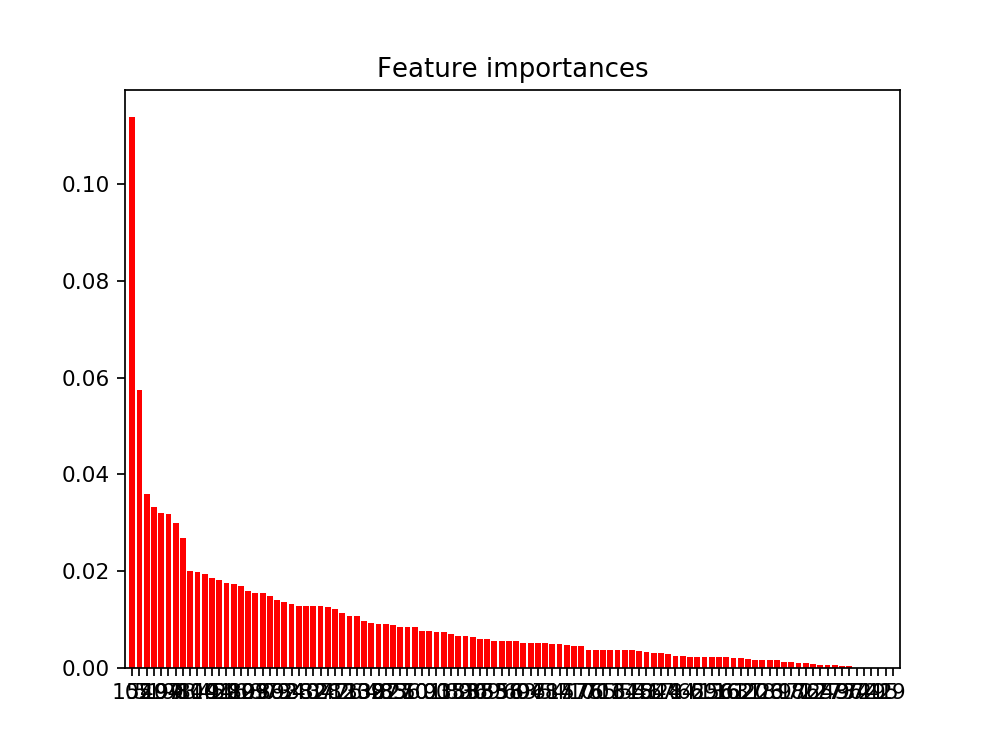

In [26]:
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
names = vectorizer.feature_names_

# Print the feature ranking
print("Feature ranking:")

for f in range(trainX.shape[1]):
    print("%d. %s (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.title("Feature importances")
plt.bar(range(trainX.shape[1]), importances[indices],
       color="r", 
        #yerr=std[indices], 
        align="center")
plt.xticks(range(trainX.shape[1]), indices)
plt.xlim([-1, trainX.shape[1]])
plt.show()

## Let's also try logistic regression.

In [122]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000)
classifier.fit(trainX,trainY)
lr_predictions= classifier.predict(testX)
accuracy_score(testY, lr_predictions)

0.6643356643356644

## Linear Regression

In [123]:
from sklearn.linear_model import RidgeClassifier
classifier = RidgeClassifier()
classifier.fit(trainX,trainY)
predictions= classifier.predict(testX)
accuracy_score(testY, predictions)

0.6223776223776224

So far our best score at predicting the districts is 0.664 using either RandomForests or LogisticRegression.  Next time we can explore hyperparameter tuning and also predicting which alliances would have been the best ones for us to join.